In [87]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull

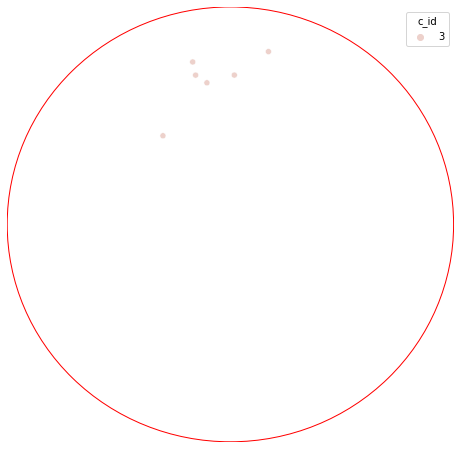

In [88]:
data_path = glob.glob('labeled_dataset/*.csv')

# Initialize sample cluster in wafer scan
wafer_df = pd.read_csv(data_path[3])
sample_cluster = wafer_df['c_id'].unique()[wafer_df['c_id'].unique() > 0][0]
cluster_df = wafer_df[wafer_df['c_id'] == sample_cluster].copy()
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=cluster_df, x='X', y='Y', hue='c_id')
circle = plt.Circle((0, 0), 150, color='r', fill=None)
ax.add_patch(circle)
ax.axis('off')
plt.setp(ax, xlim=[-150, 150], ylim=[-150, 150])
plt.show()

## 1. Create features at the wafer level and the cluster level

### Calculate number of points on wafer

In [89]:
num_wafer_pt = wafer_df.shape[0]
num_wafer_pt

27

### Calculate number of clusters detected on wafer

In [90]:
num_cluster = wafer_df.loc[wafer_df['c_id'] > 0, 'c_id'].nunique()
num_cluster

3

### Calculate centroid of wafer points

In [91]:
cent_wafer_x = wafer_df['X'].mean()
cent_wafer_y = wafer_df['Y'].mean()
print(cent_wafer_x, cent_wafer_y)

-17.43657548148148 13.407676962962963


### Calculate number of points in cluster

In [92]:
num_cluster_pt = cluster_df.shape[0]
num_cluster_pt

6

### Calculate centroid of cluster points

In [93]:
cent_cluster_x = cluster_df['X'].mean()
cent_cluster_y = cluster_df['Y'].mean()
print(cent_cluster_x, cent_cluster_y)

-13.607276166666665 99.32150283333333


### Calculate distance of cluster centroid from center

In [94]:
dist_cluster = np.sqrt(cent_cluster_x**2 + cent_cluster_y**2)
dist_cluster

100.24928373683163

### Calculate area of cluster points

In [95]:
def PolygonArea(xy):
    """Calculate the area of xy coordinates.
    
    Arg:
        xy (array): 2D array with x coordinates as the first column and 
            y coordinates as the second column
    Return:
        polygon_area (float): Area of the shape createdd by xy coordinates
    """
    x = xy[:, 0]
    y = xy[:, 1]
    x_ = x - x.mean()
    y_ = y - y.mean()
    correction = x_[-1]*y_[0] - y_[-1]*x_[0]
    main_area = np.dot(x_[:-1], y_[1:]) - np.dot(y_[:-1], x_[1:])
    polygon_area = 0.5*np.abs(main_area + correction)
    return polygon_area

def area(cluster_df):
    """Calculate the area of the outer xy coordinates of the cluster.
    
        Arg:
            cluster_df (dataframe): Cluster dataframe containing xy coordinate 
                columns
        Return:
            cluster_area (float): Area of the cluster created by outer xy 
                coordinates
    """
    cluster_xy = cluster_df[['X', 'Y']].values
    if (all(cluster_xy[:, 0] == cluster_xy[1, 0]) 
        | all(cluster_xy[:, 1] == cluster_xy[1, 1])):
        cluster_area = 0
    else:
        hull = ConvexHull(cluster_xy)
        hull_pts = cluster_xy[hull.vertices, :]
        cluster_area = PolygonArea(hull_pts)
    return cluster_area

area_cluster = area(cluster_df)
area_cluster

1224.901999193046

### Calculate length of cluster

In [96]:
def cluster_length(cluster_df):
    """Calculate the length of the cluster.
    
    Arg:
        cluster_df (dataframe): Cluster dataframe containing xy coordinate 
            columns
    Return:
        cluster_len (float): Length of the cluster that is determined by 
            the two points furthest away from each other
    """
    cluster_xy = cluster_df[['X', 'Y']].values
    dist_arr = np.sqrt(np.sum(cluster_xy**2,axis=1))
    coordA = cluster_xy[np.argmax(dist_arr), :]
    cdf_moved = cluster_xy[:] - coordA[:]
    dist_arr = np.sqrt(np.sum(cdf_moved**2,axis=1))
    coordB = cluster_xy[np.argmax(dist_arr), :]
    cluster_len = np.linalg.norm(coordA - coordB)
    return cluster_len

len_cluster = cluster_length(cluster_df)
len_cluster

91.62957028514192

## 2. Aggregate and process data for features

In [97]:
all_wafer_df = pd.concat([pd.read_csv(wafer) for wafer in data_path])

In [98]:
# Calculate features by wafer
num_wafer_pt_df = (all_wafer_df.groupby(
                   ['LOT_ID', 'WAFER_ID', 'WAFER_SCRIBE_ID'])
                         .size()
                         .reset_index())
num_wafer_pt_df.rename(columns={0: 'NUM_WAFER_PT'}, inplace=True)

cent_wafer_xy_df = (all_wafer_df.groupby(
                    ['LOT_ID', 'WAFER_ID', 'WAFER_SCRIBE_ID'])
                          .agg({'X': np.mean, 'Y': np.mean})
                          .reset_index())
cent_wafer_xy_df.rename(
    columns={'X': 'WAFER_CENTX', 'Y': 'WAFER_CENTY'}, inplace=True)

num_cluster_df = all_wafer_df.loc[all_wafer_df['c_id'] != 0, :].copy()
num_cluster_df = (num_cluster_df.groupby(
                  ['LOT_ID', 'WAFER_ID', 'WAFER_SCRIBE_ID'])
                                .agg({'c_id': 'nunique'})
                                .reset_index())
num_cluster_df.rename(
    columns={'c_id': 'NUM_CLUSTER'}, inplace=True)

# Combine all wafer features
wafer_feat_df = num_wafer_pt_df.merge(cent_wafer_xy_df)
wafer_feat_df = wafer_feat_df.merge(num_cluster_df, how='left')
wafer_feat_df['NUM_CLUSTER'].fillna(0, inplace=True)

In [99]:
#<-------20---------><-------20---------><-------20---------><-------18------->

In [ ]:
# Calculate features by clusters
num_cluster_pt_df = (all_wafer_df.groupby(
                     ['LOT_ID', 'WAFER_ID', 'WAFER_SCRIBE_ID', 'c_id'])
                                 .size()
                                 .reset_index())
num_cluster_pt_df.rename(columns={0: 'NUM_CLUSTER_PT'}, inplace=True)

cent_cluster_xy_df = (all_wafer_df.groupby(
                      ['LOT_ID', 'WAFER_ID', 'WAFER_SCRIBE_ID', 'c_id'])
                                  .agg({'X': np.mean, 'Y': np.mean})
                                  .reset_index())
cent_cluster_xy_df.rename(
    columns={'X': 'CLUSTER_CENTX', 'Y': 'CLUSTER_CENTY'}, inplace=True)

In [102]:
cent_cluster_xy_df['DIST_CLUSTER'] = np.sqrt(
    cent_cluster_xy_df['']**2 + cent_cluster_y**2)

,LOT_ID,WAFER_ID,WAFER_SCRIBE_ID,c_id,CLUSTER_CENTX,CLUSTER_CENTY
0,H9195980,163,DC2CM163JMC6,0,4.058040,-29.578752
1,H9195980,164,DC2CM164JMH0,0,-26.975621,6.105325
2,H9195980,164,DC2CM164JMH0,1,-95.551866,-60.843889
3,H9195980,164,DC2CM164JMH0,2,41.910678,-19.036785
4,H9195990,107,DC2DB107JKA2,0,-1.788092,-0.798260
...,...,...,...,...,...,...
4547,L9306030,703,M7F5A703WAA1,5,47.792946,-14.299554
4548,L9306030,711,M7F5A711WAD4,0,-11.690066,76.164832
4549,L9306030,711,M7F5A711WAD4,1,-71.244830,-92.052440
4550,L9306030,711,M7F5A711WAD4,2,-43.419197,-91.828343


In [101]:
# Combine all cluster features

## 3. Output as modeling dataset